Importing relevant libraries 

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.cluster import KMeans
import seaborn as sns
from wordcloud import WordCloud

Grabbing data from MongoDB and loading it into a dataframe 

In [58]:
client = MongoClient("mongodb://localhost:27017/")
db = client["civicIntel"]
collection = db["voicemails"]

data = list(collection.find())
vm = pd.DataFrame(data)

# clean voicemail text
import re
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # remove email boilerplate
    text = re.sub(r"This email was sent automatically with n8n", "", text)
    text = re.sub(r"https?://\S+", "", text)  # remove URLs
    
    # remove long IDs
    text = re.sub(r"_\w{40,}", "", text)
    
    # remove repeated junk words
    text = re.sub(r"\b(n8n|nodes|internal|base)\b", "", text, flags=re.IGNORECASE)
    
    # collapse extra whitespace
    text = re.sub(r"\s+", " ", text)

    
    return text.strip()

# apply cleaning
vm["text"] = vm["text"].apply(clean_text)

# Process fields
vm["timestamp"] = pd.to_datetime(vm["timestamp"], errors="coerce")
vm["text_length"] = vm["text"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)



print(vm.head(1))
print(vm.dtypes)


                        _id                 timestamp     region  \
0  68c762c452de81ed57705c32 2025-09-11 20:20:16+00:00  Northwest   

                  category sentiment  \
0  Urge Senator to do more  negative   

                                                text  text_length  
0  No I've been alive for a long time I've seen a...           91  
_id                         object
timestamp      datetime64[ns, UTC]
region                      object
category                    object
sentiment                   object
text                        object
text_length                  int64
dtype: object


Showing trends of voicemail categories over time

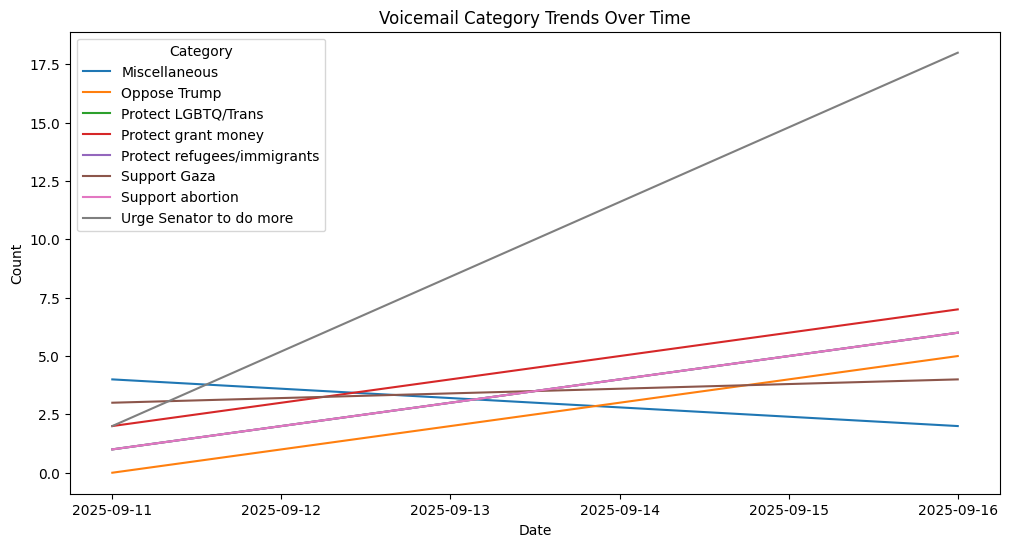

In [59]:
vm["timestamp"] = pd.to_datetime(vm["timestamp"], errors="coerce")
category_trends = vm.groupby([vm["timestamp"].dt.date, "category"]).size().unstack(fill_value=0)
category_trends.plot(kind="line", figsize=(12,6))
plt.title("Voicemail Category Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend(title="Category")
plt.show()

Displaying a heatmap of region vs. category 

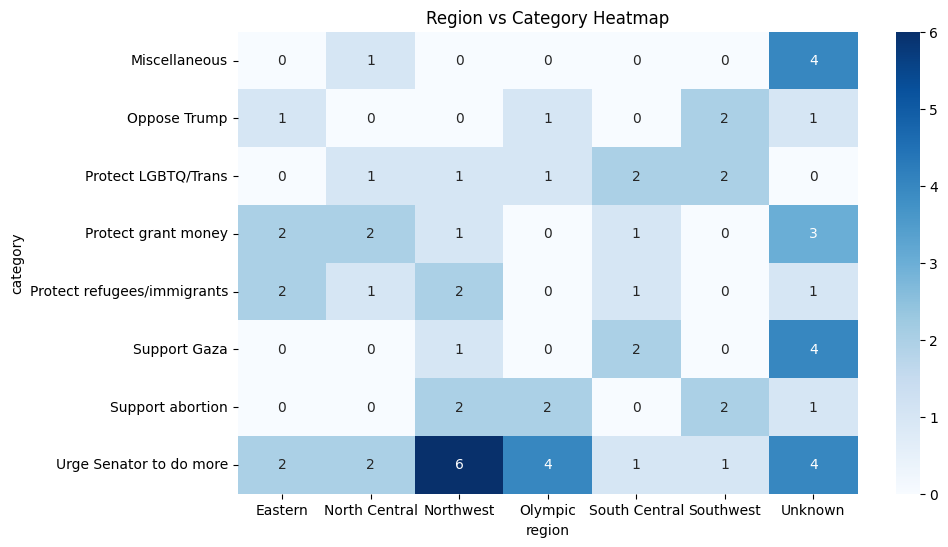

In [66]:
heatmap_data = vm.pivot_table(index="category", columns="region", values="_id", aggfunc="count", fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Region vs Category Heatmap")
plt.show()

Clustering via Unsupervised Machine Learning 

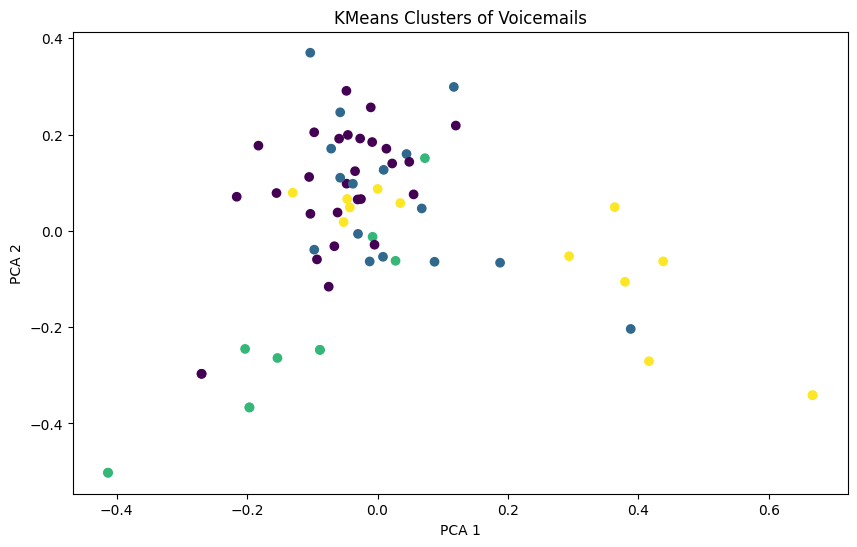

In [61]:
vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = vectorizer.fit_transform(vm["text"])


# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
vm["cluster"] = kmeans.fit_predict(X_tfidf)


# Dimensionality reduction for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())


plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=vm["cluster"], cmap="viridis")
plt.title("KMeans Clusters of Voicemails")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Topic Modeling through LDA 

In [62]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# create TF-IDF features
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(vm["text"])

# fit LDA model
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_tfidf)

# print top terms for each topic
terms = vectorizer.get_feature_names_out()
print("=== LDA Topics ===")
for i, topic in enumerate(lda.components_):
    top_terms = [terms[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_terms)}")


=== LDA Topics ===
Topic 1: lot people, ve, central, support, urge, schools, calling, people, area, lot
Topic 2: concerned, eastern, eastern wa, research, grant, programs, want, going, work, support
Topic 3: reproductive, services, small, reproductive health, federal grants, grants, central, access, access reproductive, wa
Topic 4: express, associated, institutions, access, calling say, processing, want, trump, resources, calling
Topic 5: shut, support, northwest, resident, want, money, grant money, senator, grant, stop


Matching the topics to their dominant category 

In [63]:
topic_distribution = lda.transform(X_tfidf)
vm["dominant_topic"] = topic_distribution.argmax(axis=1)
print(vm[["text", "dominant_topic"]].head(10))

                                                text  dominant_topic
0  No I've been alive for a long time I've seen a...               0
1  Please protect Gaza please oppose Israel stop ...               4
2  We are losing grant money left and right I wou...               4
3  Tell her to shut up she's dumb I hate her she'...               4
4  I just want to thank the senator for the amazi...               1
5  Hi I'm Diane a zip code 980-513 I am in South ...               4
6  I live in the Northwest region of Washington a...               4
7  Hi I'm Sarah and zip code 98105 I have a messa...               1
8  Please protect Gaza please oppose Israel stop ...               4
9  Hello my name is Bob I'm just calling to let y...               3


In [64]:
# Map each voicemail to dominant topic
topic_distribution = lda.transform(X_tfidf)
vm["dominant_topic"] = topic_distribution.argmax(axis=1)

# Label topics based on top words (manually interpreted)
terms = vectorizer.get_feature_names_out()
topic_labels = {}
for i, topic in enumerate(lda.components_):
    top_terms = [terms[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1} top terms: {', '.join(top_terms)}")

# Assign meaningful labels (example based on observed top words)
topic_label_map = {
    0: "Urge Senator / Action",
    1: "Grants / Research",
    2: "Abortion / Reproductive Health",
    3: "General Services / Trump",
    4: "Complaints / Grant Money"
}

vm["topic_label"] = vm["dominant_topic"].map(topic_label_map)

Topic 1 top terms: lot people, ve, central, support, urge, schools, calling, people, area, lot
Topic 2 top terms: concerned, eastern, eastern wa, research, grant, programs, want, going, work, support
Topic 3 top terms: reproductive, services, small, reproductive health, federal grants, grants, central, access, access reproductive, wa
Topic 4 top terms: express, associated, institutions, access, calling say, processing, want, trump, resources, calling
Topic 5 top terms: shut, support, northwest, resident, want, money, grant money, senator, grant, stop


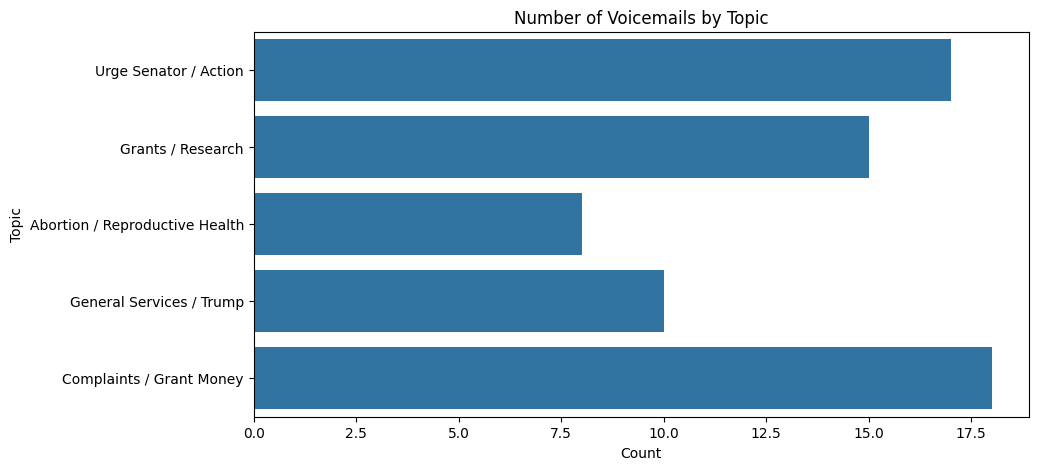

In [65]:
# Bar chart: Voicemails by topic
plt.figure(figsize=(10,5))
sns.countplot(x="topic_label", data=vm, order=topic_label_map.values())
plt.title("Number of Voicemails by Topic")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.show()